In [32]:
import numpy as np
import pyarrow as pa
import functools
import operator
import yaml
import matplotlib.pyplot as plt
import pandas as pd
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, MinMaxInterval, LogStretch
from astropy.table import Table, join
import lsst.daf.butler as dafButler
from lsst.daf.butler import DatasetNotFoundError
from lsst.pipe.base import Instrument
from lsst.ap.association.transformDiaSourceCatalog import UnpackApdbFlags
import lsst.afw.display as afwDisplay
import lsst.display.astrowidgets
afwDisplay.setDefaultBackend('astrowidgets')

In [33]:
repo = '/repo/embargo'
skymap = 'ops_rehersal_prep_2k_v1'
instrument = 'LSSTComCamSim'
collections = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'

butler = dafButler.Butler(repo, collections=collections, instrument=instrument, skymap=skymap)

In [34]:
tract, patch = 9347, 275

There are 2234 total diaSources
There are 2209 "good" diaSources
There are 198 unique visit+detectors
There are 11.2 "good" diaSources per dataId that went into this tract+patch
There are 603 total diaObjects
	 The diaObject with the most diaSources has 110 diaSources
	 and 314 (52.1%) diaObjects have just 1 diaSource


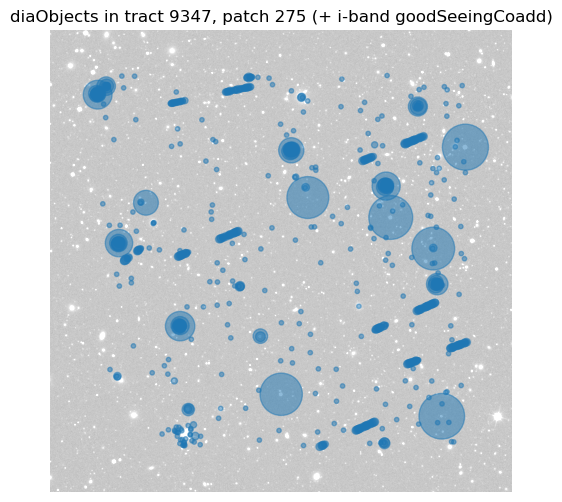

In [35]:
def diaSourceCounter(butler, instrument, tract, patch,
                     badFlagList=['pixelFlags_edge', 'pixelFlags_bad', 'pixelFlags_suspect',
                                  'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter', ]):
    """Count the number of diaSources in a goodSeeingDiff_diaSrcTable
    as well as the number of consituent visit+detector dataIds that went into it.
    Return the ratio, as a measure of "how many diaSources are there per visit+detector?"
    """
    df = butler.get('goodSeeingDiff_assocDiaSrcTable', tract=tract, patch=patch)
    nDiaSources = len(df)
    print(f'There are {nDiaSources} total diaSources')

    badFlags = [df[flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter
    nDiaSources_good = len(df.loc[noFlagFilter])
    print(f'There are {nDiaSources_good} "good" diaSources')
    
    instrumentDataId = butler.registry.expandDataId(instrument=instrument)
    packer = Instrument.from_data_id(instrumentDataId).make_default_dimension_packer(data_id=instrumentDataId, is_exposure=False)
    
    visitDetectorList = []
    for row in df['ccdVisitId'].values:
        visitDetectorList.append(packer.unpack(row))
    visitDetectorList_unique = set(visitDetectorList)
    nVisitDetectors = len(visitDetectorList_unique)
    print(f'There are {nVisitDetectors} unique visit+detectors')

    diaSourcePerVisitDetector = nDiaSources_good / nVisitDetectors
    print(f'There are {nDiaSources_good / nVisitDetectors:.1f} "good" diaSources per dataId that went into this tract+patch')

    dfObj = butler.get('goodSeeingDiff_diaObjTable', tract=tract, patch=patch)
    nDiaObjects = len(dfObj)
    print(f'There are {nDiaObjects} total diaObjects')
    print(f'\t The diaObject with the most diaSources has {np.max(dfObj.nDiaSources)} diaSources')
    nDiaObjectsWithOneDiaSource = len(dfObj.loc[dfObj.nDiaSources==1])
    print(f'\t and {nDiaObjectsWithOneDiaSource} ({nDiaObjectsWithOneDiaSource/nDiaObjects*100:.1f}%) diaObjects have just 1 diaSource')
    
    band = 'i'
    try:
        coadd = butler.get('goodSeeingCoadd', tract=tract, patch=patch, band=band)
    except DatasetNotFoundError:  # load r-band instead
        band = 'r'
        coadd = butler.get('goodSeeingCoadd', tract=tract, patch=patch, band=band)

    plt.figure(figsize=(6,6))
    ax1 = plt.gca()
    coadd.setXY0(lsst.geom.Point2I(0,0))  # so we can plot everything in naive patch xycoords
    xycoords = coadd.wcs.skyToPixelArray(ra=dfObj['ra'], dec=dfObj['dec'], degrees=True)
    norm = ImageNormalize(coadd.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    ax1.imshow(coadd.image.array, origin='lower', norm=norm, cmap='gray', alpha=0.5)
    ax1.scatter(xycoords[0], xycoords[1], alpha=0.5, s=dfObj['nDiaSources']*10)
    plt.axis('off')
    
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    #plt.scatter(df['ra'], df['dec'], alpha=0.3, s=3)
    #plt.scatter(df.loc[noFlagFilter, 'ra'], df.loc[noFlagFilter, 'dec'], alpha=0.3, s=3)
    #ax1.scatter(dfObj['ra'], dfObj['dec'], alpha=0.5, s=dfObj['nDiaSources']*10)
    #ax1.invert_xaxis()
    # get axes limits for the full patch
    
    #ax1.set_xlabel('RA (deg)')
    #ax1.set_ylabel('Dec (deg)')
    plt.title(f'diaObjects in tract {tract}, patch {patch} (+ {band}-band goodSeeingCoadd)')
    #fig.tight_layout()
    #ax2.imshow(coadd.image.array, origin='lower', norm=norm, cmap='gray')
    plt.show()

diaSourceCounter(butler, instrument, tract, patch)

In [36]:
def getSources(butler, instrument, tract, patch,
                     badFlagList=['pixelFlags_edge', 'pixelFlags_bad', 'pixelFlags_suspect',
                                  'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter', ]):
    df = butler.get('goodSeeingDiff_assocDiaSrcTable', tract=tract, patch=patch)
    nDiaSources = len(df)
    print(f'There are {nDiaSources} total diaSources')

    badFlags = [df[flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter
    nDiaSources_good = len(df.loc[noFlagFilter])
    print(f'There are {nDiaSources_good} "good" diaSources')
    return df
    
    instrumentDataId = butler.registry.expandDataId(instrument=instrument)
    packer = Instrument.from_data_id(instrumentDataId).make_default_dimension_packer(data_id=instrumentDataId, is_exposure=False)
    
    visitDetectorList = []
    for row in df['ccdVisitId'].values:
        visitDetectorList.append(packer.unpack(row))
    visitDetectorList_unique = set(visitDetectorList)
    nVisitDetectors = len(visitDetectorList_unique)
    print(f'There are {nVisitDetectors} unique visit+detectors')

    diaSourcePerVisitDetector = nDiaSources_good / nVisitDetectors
    print(f'There are {nDiaSources_good / nVisitDetectors:.1f} "good" diaSources per dataId that went into this tract+patch')

    dfObj = butler.get('goodSeeingDiff_diaObjTable', tract=tract, patch=patch)
    nDiaObjects = len(dfObj)
    print(f'There are {nDiaObjects} total diaObjects')
    print(f'\t The diaObject with the most diaSources has {np.max(dfObj.nDiaSources)} diaSources')
    nDiaObjectsWithOneDiaSource = len(dfObj.loc[dfObj.nDiaSources==1])
    print(f'\t and {nDiaObjectsWithOneDiaSource} ({nDiaObjectsWithOneDiaSource/nDiaObjects*100:.1f}%) diaObjects have just 1 diaSource')

srcs = getSources(butler=butler, instrument=instrument, tract=tract, patch=patch)

There are 2234 total diaSources
There are 2209 "good" diaSources


In [37]:
srcs

,ccdVisitId,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,dec,...,shape_flag_parent_source,ext_trailedSources_Naive_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec
diaSourceId,,,,,,,,,,,,,,,,,,,,,
3065438781168418929,730857558529,g,2970394434111275011,0,0,60403.177583,29,2024-04-08 02:09:36.038498,179.672172,0.017580,...,False,False,False,False,False,False,False,False,179.672171,0.017571
3065438710309847084,730857541635,g,2970394434111275011,0,0,60403.126133,30,2024-04-08 01:58:00.645018,179.672172,0.017581,...,False,False,False,False,False,False,False,False,179.672171,0.017571
3065438777955581999,730857557763,g,2970394434111275011,0,0,60403.176149,30,2024-04-08 02:08:30.592207,179.672170,0.017574,...,False,False,False,False,False,False,False,False,179.672171,0.017571
3065438797282934888,730857562371,i,2970394434111275011,0,0,60403.186121,28,2024-04-08 01:44:51.156544,179.672172,0.017569,...,False,False,False,False,False,False,False,False,179.672171,0.017571
3065438801577902151,730857563395,i,2970394434111275011,0,0,60403.188035,29,2024-04-08 02:17:42.838953,179.672178,0.017585,...,False,False,False,False,False,False,False,False,179.672171,0.017571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065438739321847852,730857548552,i,2970394434111275298,0,0,60403.140466,8,2024-04-08 01:42:53.505993,179.715407,0.016960,...,False,False,False,False,False,False,False,False,179.715407,0.016960
3065438755427975240,730857552392,r,2970394434111275383,0,0,60403.164744,21,2024-04-08 01:32:13.170541,179.730091,0.031404,...,False,False,False,False,False,False,False,False,179.730091,0.031404
3065438759722942535,730857553416,r,2970394434111275401,0,0,60403.166658,21,2024-04-08 01:39:21.796517,179.729694,0.031480,...,False,False,False,False,False,False,False,False,179.729694,0.031480


Now, let's pull in the input data (simulated asteroids). These should have the exposure times in the `mjd` column.

In [38]:
import glob
df = pd.concat(map(pd.read_parquet, glob.glob('skyCatalogs/sso_[0-9]*.parquet')))
df

,id,mjd,ra,dec,trailed_source_mag,ra_rate,dec_rate
0,2015 GZ59,60390.32948,250.343046,2.436285,22.606934,0.066040,0.204506
1,S100COSsa,60390.32948,250.322487,2.471915,25.847629,0.044831,0.078832
2,S100aRt2a,60390.32948,250.357532,2.440407,22.970990,0.082879,0.057274
3,2015 GZ59,60390.32988,250.343065,2.436364,22.606929,0.066033,0.204506
4,S100COSsa,60390.32988,250.322507,2.471947,25.847624,0.044823,0.078831
...,...,...,...,...,...,...,...
541,2015 WK16,60409.97708,125.370575,-15.587466,22.514165,0.141911,0.176302
542,S102wi2Ba,60409.98442,125.521864,-15.491638,27.303297,0.185266,0.155677
543,S102wi2Ba,60409.98603,125.522170,-15.491392,27.303324,0.185273,0.155698
544,2015 WK16,60409.98883,125.372242,-15.585396,23.164365,0.141943,0.176399


Let's get some situational awareness...

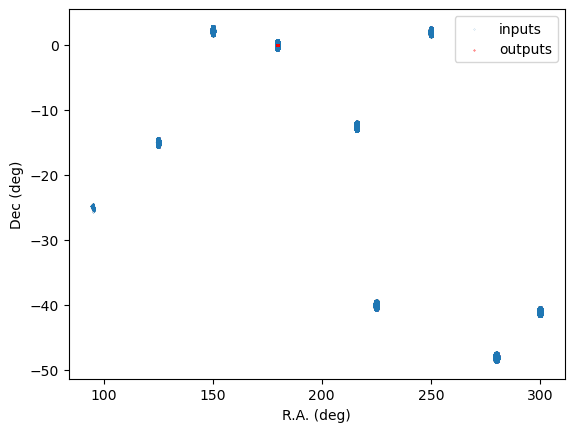

In [39]:
plt.scatter(df["ra"], df["dec"], s=0.01, label="inputs")
plt.scatter(srcs["ra"], srcs["dec"], s=0.1, color='red', label="outputs")
plt.xlabel("R.A. (deg)")
plt.ylabel("Dec (deg)")
plt.legend()

Restrict ourselves to ~10 deg around the output patch:

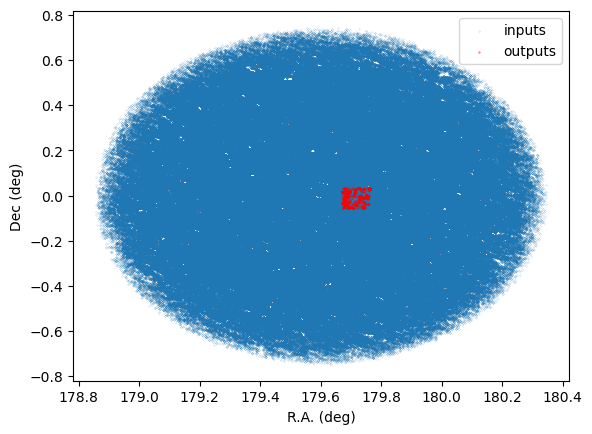

In [42]:
from astropy.coordinates import SkyCoord
ctr = SkyCoord(srcs["ra"].median(), srcs["dec"].median(), frame='icrs', unit='deg')
sep = SkyCoord(df["ra"].values, df["dec"].values, frame='icrs', unit='deg').separation(ctr)

df2 = df.iloc[sep.degree < 10]
plt.scatter(df2["ra"], df2["dec"], s=0.01, label="inputs")
plt.scatter(srcs["ra"], srcs["dec"], s=0.1, color='red', label="outputs")
plt.xlabel("R.A. (deg)")
plt.ylabel("Dec (deg)")
plt.legend()

Now let's try to find the nearest MJDs...

In [43]:
def find_nearest(array, value):
    # Returns the item from array that's nearest to <value>
    # <value> can be an array itself (in that case, an array is returned).
    # h/t to sama & co.
    array = np.asarray(array)
    if np.isscalar(value):
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        nearest_values = np.zeros_like(value)
        for i, v in enumerate(value):
            idx = (np.abs(array - v)).argmin()
            nearest_values[i] = array[idx]
        return nearest_values

In [45]:
outmjds

array([60403.1099351 , 60403.11041649, 60403.11089578, 60403.11137461,
       60403.1118527 , 60403.11233029, 60403.11280856, 60403.11328697,
       60403.11376523, 60403.11424052, 60403.11472031, 60403.11519833,
       60403.11567768, 60403.11615875, 60403.11663905, 60403.11711818,
       60403.11759689, 60403.1180747 , 60403.11855357, 60403.11903069,
       60403.12085869, 60403.12133704, 60403.12181731, 60403.12229563,
       60403.12277419, 60403.12325394, 60403.12373258, 60403.12421326,
       60403.12469459, 60403.12517504, 60403.12565549, 60403.12613303,
       60403.12661106, 60403.12708967, 60403.1275679 , 60403.12852553,
       60403.12900689, 60403.12948543, 60403.12996558, 60403.1317935 ,
       60403.13227117, 60403.13274944, 60403.13322891, 60403.13370807,
       60403.13418682, 60403.13466865, 60403.13514995, 60403.1356272 ,
       60403.13610303, 60403.13706048, 60403.13753931, 60403.13802016,
       60403.13854935, 60403.13903011, 60403.13950881, 60403.13998767,
      

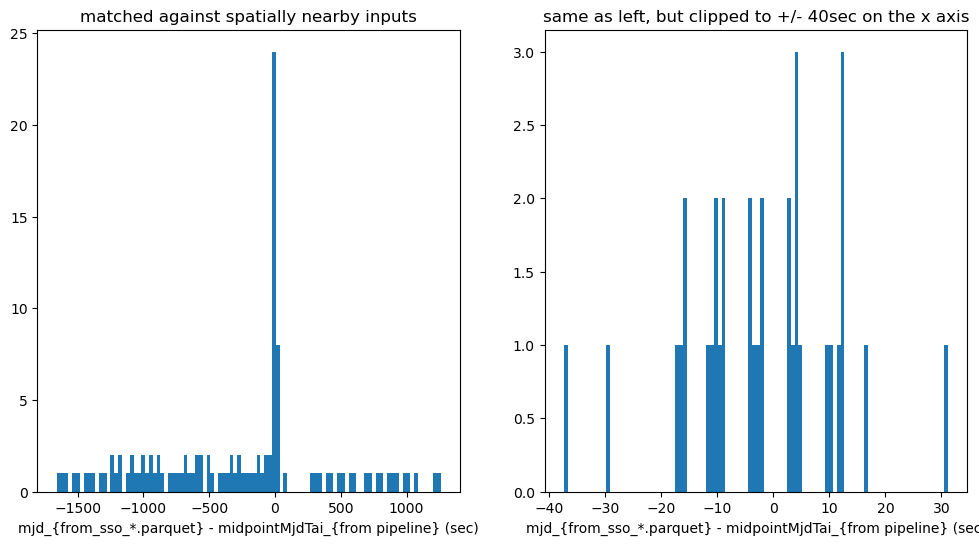

In [75]:
inmjds = np.unique(df2["mjd"].values)
outmjds = np.unique(srcs["midpointMjdTai"].values)

nearest = find_nearest(inmjds, outmjds)
dt = (nearest - outmjds)*24*3600

fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].hist(dt, bins=100)
ax[0].set_xlabel("mjd_{from_sso_*.parquet} - midpointMjdTai_{from pipeline} (sec)")
ax[0].set_title("matched against spatially nearby inputs")

# We'll clip to +/-40 sec, as there seem to be many inputs with times out of range
ax[1].hist(dt[np.abs(dt) < 40], bins=100)
ax[1].set_xlabel("mjd_{from_sso_*.parquet} - midpointMjdTai_{from pipeline} (sec)")
ax[1].set_title("same as left, but clipped to +/- 40sec on the x axis")
plt.show()

In [66]:
# quick sanity check
mjd = outmjds[0]; print((inmjds[np.searchsorted(inmjds, 60403.1099351)-1] - mjd)*24*3600)
mjd = outmjds[0]; print((inmjds[np.searchsorted(inmjds, 60403.1099351)] - mjd)*24*3600)
mjd = outmjds[0]; print((inmjds[np.searchsorted(inmjds, 60403.1099351)+1] - mjd)*24*3600)

-22.04050230793655
12.519497447647154
46.2154975393787
